# BUSI Multi‑Task CNN (Segmentation + Classification) with Grad‑CAM

> Solid multi‑task baseline (seg + cls) + interpretable Grad‑CAM + ready‑to‑export figures & CSV metrics.

## 0) Setup & Reproducibility

In [5]:
# !pip install albumentations==1.4.8 --quiet
import os, random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda


## 1) Data Path (robust Kaggle/KaggleHub fallback)

In [6]:
import os

# Preferred (Kaggle datasets):
DEFAULT_DATA_PATH = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

# Optional fallback via kagglehub (only if internet is allowed in your environment)
DATA_PATH = DEFAULT_DATA_PATH
if not os.path.exists(DATA_PATH):
    try:
        import kagglehub
        root = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
        DATA_PATH = os.path.join(root, "Dataset_BUSI_with_GT")
        print("Using kagglehub path:", DATA_PATH)
    except Exception as e:
        print("kagglehub not available, please add the dataset via Kaggle Datasets tab.")
        raise e

assert os.path.exists(DATA_PATH), f"DATA_PATH not found: {DATA_PATH}"
print("DATA_PATH:", DATA_PATH)

DATA_PATH: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT


## 2) Index Files & Train/Val Split

In [7]:
import glob
from sklearn.model_selection import train_test_split

classes = ["benign", "malignant", "normal"]
image_paths, mask_paths, labels = [], [], []

for idx, cls in enumerate(classes):
    img_dir = os.path.join(DATA_PATH, cls)
    imgs = sorted(glob.glob(os.path.join(img_dir, "*.png")))
    for img in imgs:
        if img.endswith("_mask.png"):
            continue
        mask = img.replace('.png', '_mask.png')
        if os.path.exists(mask):
            image_paths.append(img)
            mask_paths.append(mask)
            labels.append(idx)  # 0=benign, 1=malignant, 2=normal

print(f"Total samples: {len(image_paths)}")
print("Example:", image_paths[0])

SEED = 42
train_imgs, val_imgs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    image_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)

print("Train:", len(train_imgs), "Validation:", len(val_imgs))

Total samples: 780
Example: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1).png
Train: 624 Validation: 156


## 3) Augmentations (Albumentations)

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ImageNet stats for ResNet50
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

## 4) Dataset & DataLoader (fixed mask shapes)

In [9]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import torch

class BUSIDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype('float32')  # robust binarization

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]               # (3,H,W)
            mask = augmented["mask"].unsqueeze(0)  # (1,H,W)
        else:
            img = torch.from_numpy(img).permute(2,0,1).float()/255.0
            mask = torch.from_numpy(mask).unsqueeze(0)

        label = self.labels[idx]
        return img, mask, label

train_dataset = BUSIDataset(train_imgs, train_masks, train_labels, transform=train_transform)
val_dataset   = BUSIDataset(val_imgs,   val_masks,   val_labels,   transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print("Batches — train:", len(train_loader), "val:", len(val_loader))

Batches — train: 39 val: 10


## 5) Multi‑Task Model (ResNet50 backbone)

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.shared = nn.Sequential(*list(backbone.children())[:-2])

        self.seg_head = nn.Sequential(
            nn.Conv2d(2048, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 1, kernel_size=1)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        feats = self.shared(x)
        seg_logits = self.seg_head(feats)
        cls_logits = self.fc(self.avgpool(feats).flatten(1))
        return seg_logits, cls_logits

model = MultiTaskCNN(num_classes=3).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s] 


## 6) Losses, Optimizer, Scheduler

In [11]:
import torch.optim as optim

loss_seg = nn.BCEWithLogitsLoss()
loss_cls = nn.CrossEntropyLoss()

w_seg, w_cls = 1.0, 1.0
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 7) Metrics (Dice / IoU / Accuracy)

In [33]:
import torch

def dice_from_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    targets = targets.float()
    intersect = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2*intersect + eps) / (union + eps)
    return dice.mean().item()

def iou_from_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    targets = targets.float()
    intersect = (preds * targets).sum(dim=(1,2,3))
    total = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersect
    iou = (intersect + eps) / (total + eps)
    return iou.mean().item()

def acc_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

## 8) Train & Validate Loop (saves best by Dice/Acc combo)

In [13]:
from tqdm.auto import tqdm
import numpy as np

EPOCHS = 15
best_combo = -np.inf
SAVE_PATH = "/kaggle/working/best_multitask.pth"

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss = tr_dice = tr_iou = tr_acc = 0.0

    for imgs, masks, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        imgs   = imgs.to(DEVICE, non_blocking=True)
        masks  = masks.to(DEVICE, non_blocking=True)
        labels = torch.as_tensor(labels, device=DEVICE)

        optimizer.zero_grad(set_to_none=True)
        seg_logits, cls_logits = model(imgs)

        loss_s = loss_seg(seg_logits, masks)
        loss_c = loss_cls(cls_logits, labels)
        loss = w_seg * loss_s + w_cls * loss_c
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        tr_dice += dice_from_logits(seg_logits.detach(), masks)
        tr_iou  += iou_from_logits(seg_logits.detach(), masks)
        tr_acc  += acc_from_logits(cls_logits.detach(), labels)

    n_batches = len(train_loader)
    tr_loss /= n_batches
    tr_dice /= n_batches
    tr_iou  /= n_batches
    tr_acc  /= n_batches

    model.eval()
    va_loss = va_dice = va_iou = va_acc = 0.0
    with torch.no_grad():
        for imgs, masks, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Valid]"):
            imgs   = imgs.to(DEVICE, non_blocking=True)
            masks  = masks.to(DEVICE, non_blocking=True)
            labels = torch.as_tensor(labels, device=DEVICE)

            seg_logits, cls_logits = model(imgs)
            loss_s = loss_seg(seg_logits, masks)
            loss_c = loss_cls(cls_logits, labels)
            loss = w_seg * loss_s + w_cls * loss_c

            va_loss += loss.item()
            va_dice += dice_from_logits(seg_logits, masks)
            va_iou  += iou_from_logits(seg_logits, masks)
            va_acc  += acc_from_logits(cls_logits, labels)

    n_val = len(val_loader)
    va_loss /= n_val
    va_dice /= n_val
    va_iou  /= n_val
    va_acc  /= n_val

    combo = (va_dice + va_acc) / 2.0
    print(f"\nEpoch {epoch}: Train Loss {tr_loss:.4f} | Dice {tr_dice:.4f} IoU {tr_iou:.4f} Acc {tr_acc:.4f} || "
          f"Val Loss {va_loss:.4f} | Dice {va_dice:.4f} IoU {va_iou:.4f} Acc {va_acc:.4f}")

    scheduler.step(va_dice)

    if combo > best_combo:
        best_combo = combo
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "w_seg": w_seg, "w_cls": w_cls
        }, SAVE_PATH)
        print(f"✅ Saved new best model (combo={combo:.4f}) -> {SAVE_PATH}")

Epoch 1/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1: Train Loss 1.1126 | Dice 0.1350 IoU 0.1328 Acc 0.6827 || Val Loss 0.7924 | Dice 0.1729 IoU 0.1729 Acc 0.8021
✅ Saved new best model (combo=0.4875) -> /kaggle/working/best_multitask.pth


Epoch 2/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eee73d7bc40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
<function _MultiProcessingDataLoaderIter.__del__ at 0x7eee73d7bc40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^^<function _Multi

Epoch 2/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 2: Train Loss 0.6424 | Dice 0.1699 IoU 0.1699 Acc 0.8349 || Val Loss 0.5814 | Dice 0.1743 IoU 0.1737 Acc 0.8688
✅ Saved new best model (combo=0.5215) -> /kaggle/working/best_multitask.pth


Epoch 3/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 3: Train Loss 0.4747 | Dice 0.1856 IoU 0.1803 Acc 0.8782 || Val Loss 0.5769 | Dice 0.2827 IoU 0.2451 Acc 0.7854
✅ Saved new best model (combo=0.5340) -> /kaggle/working/best_multitask.pth


Epoch 4/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 4: Train Loss 0.3978 | Dice 0.3830 IoU 0.3227 Acc 0.9151 || Val Loss 0.6725 | Dice 0.4946 IoU 0.4090 Acc 0.7833
✅ Saved new best model (combo=0.6389) -> /kaggle/working/best_multitask.pth


Epoch 5/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 5: Train Loss 0.3875 | Dice 0.4816 IoU 0.4032 Acc 0.9119 || Val Loss 0.5837 | Dice 0.3355 IoU 0.2885 Acc 0.8708


Epoch 6/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 6: Train Loss 0.3022 | Dice 0.4995 IoU 0.4245 Acc 0.9487 || Val Loss 0.5059 | Dice 0.4270 IoU 0.3664 Acc 0.8729
✅ Saved new best model (combo=0.6500) -> /kaggle/working/best_multitask.pth


Epoch 7/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 7: Train Loss 0.2764 | Dice 0.5399 IoU 0.4604 Acc 0.9375 || Val Loss 0.5123 | Dice 0.5967 IoU 0.5173 Acc 0.8917
✅ Saved new best model (combo=0.7442) -> /kaggle/working/best_multitask.pth


Epoch 8/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 8: Train Loss 0.2259 | Dice 0.5846 IoU 0.5027 Acc 0.9647 || Val Loss 0.5928 | Dice 0.5743 IoU 0.4994 Acc 0.8792


Epoch 9/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 9: Train Loss 0.2547 | Dice 0.5753 IoU 0.4928 Acc 0.9503 || Val Loss 0.4985 | Dice 0.5807 IoU 0.5096 Acc 0.9104
✅ Saved new best model (combo=0.7455) -> /kaggle/working/best_multitask.pth


Epoch 10/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 10: Train Loss 0.2193 | Dice 0.6158 IoU 0.5288 Acc 0.9583 || Val Loss 0.4579 | Dice 0.6326 IoU 0.5512 Acc 0.9250
✅ Saved new best model (combo=0.7788) -> /kaggle/working/best_multitask.pth


Epoch 11/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 11/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 11: Train Loss 0.1731 | Dice 0.6439 IoU 0.5501 Acc 0.9744 || Val Loss 0.4307 | Dice 0.5664 IoU 0.4941 Acc 0.9042


Epoch 12/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 12/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 12: Train Loss 0.1554 | Dice 0.6323 IoU 0.5427 Acc 0.9760 || Val Loss 0.4616 | Dice 0.6502 IoU 0.5564 Acc 0.9104
✅ Saved new best model (combo=0.7803) -> /kaggle/working/best_multitask.pth


Epoch 13/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 13/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 13: Train Loss 0.1700 | Dice 0.6413 IoU 0.5486 Acc 0.9728 || Val Loss 0.6259 | Dice 0.6406 IoU 0.5535 Acc 0.8417


Epoch 14/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eee73d7bc40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7eee73d7bc40>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
     ^ ^ ^  ^  ^ ^ ^ ^^^^^^^^^^
^  File

Epoch 14/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eee73d7bc40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eee73d7bc40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 14: Train Loss 0.1672 | Dice 0.6878 IoU 0.5912 Acc 0.9744 || Val Loss 0.5498 | Dice 0.5160 IoU 0.4412 Acc 0.8812


Epoch 15/15 [Train]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 15/15 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 15: Train Loss 0.1620 | Dice 0.6708 IoU 0.5766 Acc 0.9792 || Val Loss 0.5115 | Dice 0.5197 IoU 0.4489 Acc 0.9104


## 9) Confusion Matrix & Classification Report (Validation)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import os

@torch.no_grad()
def evaluate_classification(val_loader, model, num_classes=3):
    model.eval()
    all_preds, all_labels = [], []
    for imgs, masks, labels in val_loader:
        imgs = imgs.to(DEVICE)
        labels = torch.as_tensor(labels, device=DEVICE)
        _, cls_logits = model(imgs)
        preds = torch.argmax(cls_logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    return y_true, y_pred

# Load best
if os.path.exists(SAVE_PATH):
    ckpt = torch.load(SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best checkpoint from epoch {ckpt.get('epoch','?')}")

idx_to_class = {0: "benign", 1: "malignant", 2: "normal"}
y_true, y_pred = evaluate_classification(val_loader, model, num_classes=3)
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
report = classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in [0,1,2]], output_dict=True)

cm_df = pd.DataFrame(cm, index=["true_benign","true_malignant","true_normal"], columns=["pred_benign","pred_malignant","pred_normal"])
rep_df = pd.DataFrame(report).transpose()

print("Confusion Matrix:\n", cm_df)
print("\nClassification Report:\n", rep_df)

os.makedirs('/kaggle/working/results', exist_ok=True)
cm_df.to_csv('/kaggle/working/results/confusion_matrix.csv', index=True)
rep_df.to_csv('/kaggle/working/results/classification_report.csv', index=True)
print("Saved CSVs to /kaggle/working/results/")

Loaded best checkpoint from epoch 12
Confusion Matrix:
                 pred_benign  pred_malignant  pred_normal
true_benign              81               2            4
true_malignant            4              38            0
true_normal               4               0           23

Classification Report:
               precision    recall  f1-score     support
benign         0.910112  0.931034  0.920455   87.000000
malignant      0.950000  0.904762  0.926829   42.000000
normal         0.851852  0.851852  0.851852   27.000000
accuracy       0.910256  0.910256  0.910256    0.910256
macro avg      0.903988  0.895883  0.899712  156.000000
weighted avg   0.910768  0.910256  0.910297  156.000000
Saved CSVs to /kaggle/working/results/


## 10) Validation Metrics Table (Dice, IoU, Acc) → CSV

In [15]:
@torch.no_grad()
def evaluate_seg_cls(val_loader, model):
    model.eval()
    losses, dices, ious, accs = [], [], [], []
    for imgs, masks, labels in val_loader:
        imgs   = imgs.to(DEVICE)
        masks  = masks.to(DEVICE)
        labels = torch.as_tensor(labels, device=DEVICE)
        seg_logits, cls_logits = model(imgs)
        loss = w_seg * loss_seg(seg_logits, masks) + w_cls * loss_cls(cls_logits, labels)
        losses.append(loss.item())
        dices.append(dice_from_logits(seg_logits, masks))
        ious.append(iou_from_logits(seg_logits, masks))
        accs.append(acc_from_logits(cls_logits, labels))
    return {
        'val_loss': float(np.mean(losses)),
        'val_dice': float(np.mean(dices)),
        'val_iou':  float(np.mean(ious)),
        'val_acc':  float(np.mean(accs)),
    }

metrics = evaluate_seg_cls(val_loader, model)
import pandas as pd
metrics_df = pd.DataFrame([metrics])
print(metrics_df)

os.makedirs('/kaggle/working/results', exist_ok=True)
metrics_df.to_csv('/kaggle/working/results/metrics_summary.csv', index=False)
print("Saved /kaggle/working/results/metrics_summary.csv")

   val_loss  val_dice  val_iou   val_acc
0  0.461613  0.650185  0.55636  0.910417
Saved /kaggle/working/results/metrics_summary.csv


## 11) Grad‑CAM (fixed hooks) + 5‑Panel Visualization

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

class GradCAM:
    """Grad-CAM on a target conv layer for the classification head."""
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.fwd_hook = self.target_layer.register_forward_hook(self._save_activations)
        self.bwd_hook = self.target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output.detach()

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    @torch.no_grad()
    def _normalize_cam(self, cam):
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        return cam

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        input_tensor.requires_grad_(True)
        seg_logits, cls_logits = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(cls_logits, dim=1).item()
        score = cls_logits[0, class_idx]
        score.backward(retain_graph=True)

        weights = self.gradients.mean(dim=(2,3), keepdim=True)[0]
        activs  = self.activations[0]
        cam = (weights * activs).sum(dim=0)
        cam = F.relu(cam)
        cam = cam.unsqueeze(0).unsqueeze(0)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = self._normalize_cam(cam)
        return cam, torch.softmax(cls_logits, dim=1).detach().cpu().numpy()[0], seg_logits

    def close(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

def get_target_layer(model):
    layer4 = model.shared[-1]
    last_block = list(layer4.children())[-1]
    return last_block.conv3

IMAGENET_MEAN_ARR = np.array([0.485, 0.456, 0.406])
IMAGENET_STD_ARR  = np.array([0.229, 0.224, 0.225])

def tensor_to_image_uint8(t):
    x = t.detach().cpu().numpy()
    x = np.transpose(x, (1,2,0))
    x = (x * IMAGENET_STD_ARR + IMAGENET_MEAN_ARR)
    x = np.clip(x, 0, 1)
    return (x * 255).astype(np.uint8)

def logits_to_mask_uint8(seg_logits):
    probs = torch.sigmoid(seg_logits).detach().cpu().numpy()[0,0]
    pred = (probs > 0.5).astype(np.uint8) * 255
    return pred

def overlay_heatmap(img_rgb, cam, alpha=0.35):
    heatmap = (cam * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:, :, ::-1]
    return cv2.addWeighted(img_rgb, 1.0, heat, alpha, 0)

def show_5panel(img_rgb, gt_mask_uint8, pred_mask_uint8, cam, title_left, pred_class_name, pred_prob, save_path=None):
    overlay = overlay_heatmap(img_rgb, cam)
    plt.figure(figsize=(14,3))
    plt.subplot(1,5,1); plt.imshow(img_rgb); plt.title("Original"); plt.axis('off')
    plt.subplot(1,5,2); plt.imshow(gt_mask_uint8, cmap='gray'); plt.title("GT Mask"); plt.axis('off')
    plt.subplot(1,5,3); plt.imshow(pred_mask_uint8, cmap='gray'); plt.title("Pred Mask"); plt.axis('off')
    plt.subplot(1,5,4); plt.imshow(cam, vmin=0, vmax=1); plt.title("Grad-CAM"); plt.axis('off')
    plt.subplot(1,5,5); plt.imshow(overlay); plt.title(f"Overlay\n{pred_class_name} ({pred_prob:.2f})"); plt.axis('off')
    plt.suptitle(title_left, y=1.05, fontsize=12)
    plt.tight_layout()
    if save_path is not None:
        Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

## 12) Demo: Grad‑CAM on Validation Samples

Loaded checkpoint from epoch 12


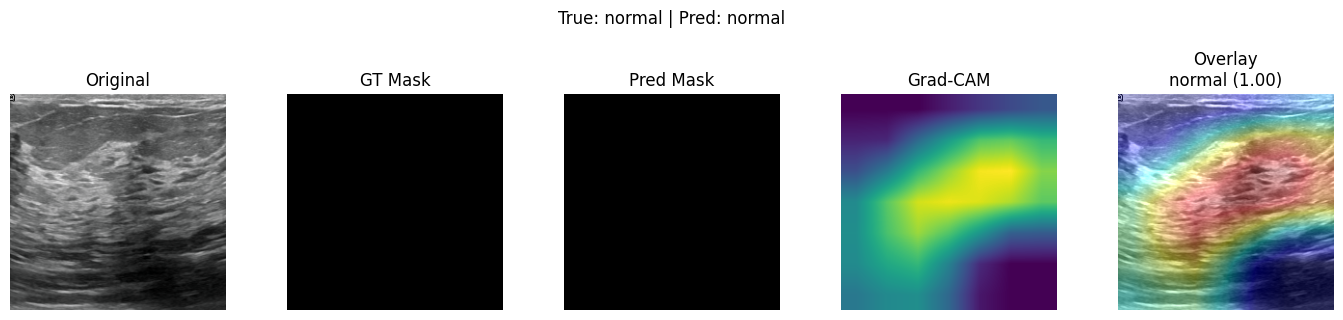

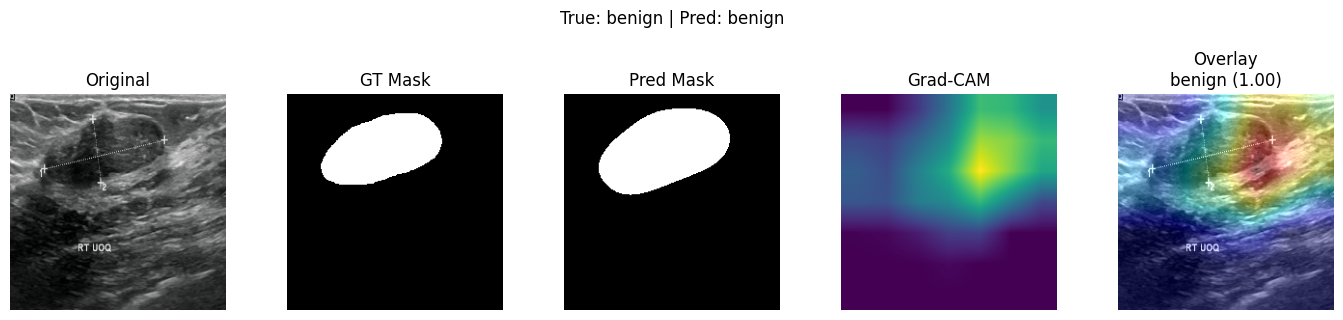

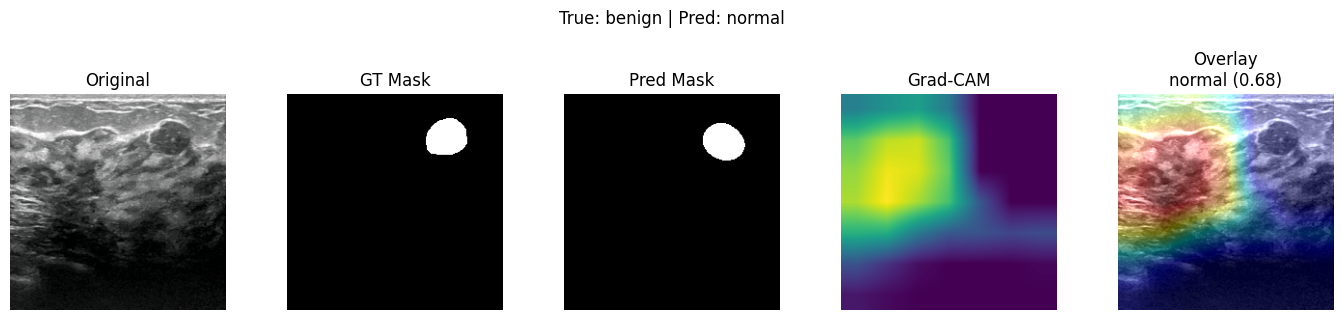

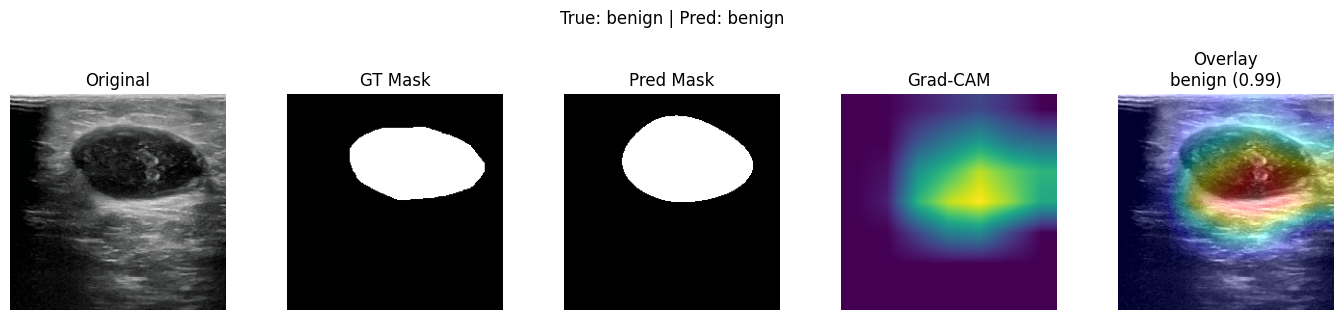

In [17]:
# Load best checkpoint if present
if os.path.exists(SAVE_PATH):
    ckpt = torch.load(SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    print(f"Loaded checkpoint from epoch {ckpt.get('epoch','?')}")

model.eval()
idx_to_class = {0: "benign", 1: "malignant", 2: "normal"}

target_layer = get_target_layer(model)
cam_engine = GradCAM(model, target_layer)

n_to_show = 4
shown = 0

for imgs, masks, labels in val_loader:  # keep grads enabled for CAM
    imgs = imgs.to(DEVICE)
    masks_t = masks.to(DEVICE)
    labels_t = torch.as_tensor(labels, device=DEVICE)

    seg_logits, cls_logits = model(imgs)

    for b in range(imgs.size(0)):
        if shown >= n_to_show:
            break
        single = imgs[b].unsqueeze(0)
        cam_engine.model.zero_grad()
        cam, probs, seg_logits_single = cam_engine.generate(single)

        img_uint8   = tensor_to_image_uint8(imgs[b])
        gt_mask_u8  = (masks_t[b,0].detach().float().cpu().numpy() > 0.5).astype(np.uint8) * 255
        pred_mask_u8= logits_to_mask_uint8(seg_logits[b].unsqueeze(0))

        pred_idx  = int(np.argmax(probs))
        pred_name = idx_to_class[pred_idx]
        true_name = idx_to_class[int(labels_t[b].item())]
        title = f"True: {true_name} | Pred: {pred_name}"

        show_5panel(
            img_uint8, gt_mask_u8, pred_mask_u8, cam,
            title_left=title,
            pred_class_name=pred_name,
            pred_prob=float(probs.max()),
            save_path=f"/kaggle/working/figures/sample_{shown+1}.png"
        )
        shown += 1
    if shown >= n_to_show:
        break

cam_engine.close()

## 13) One‑Click Export of N Validation Figures

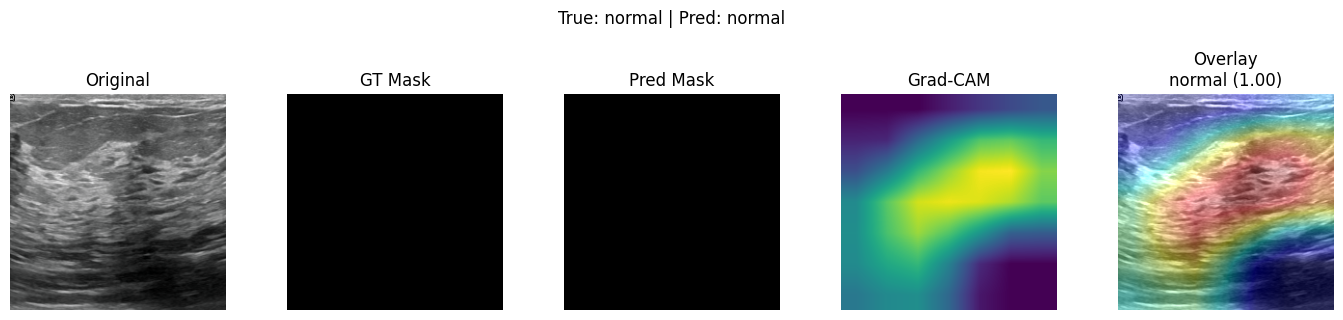

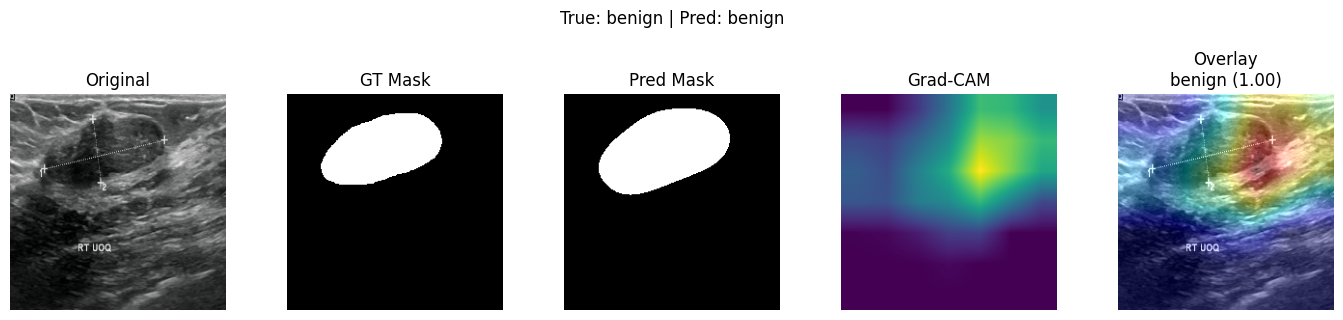

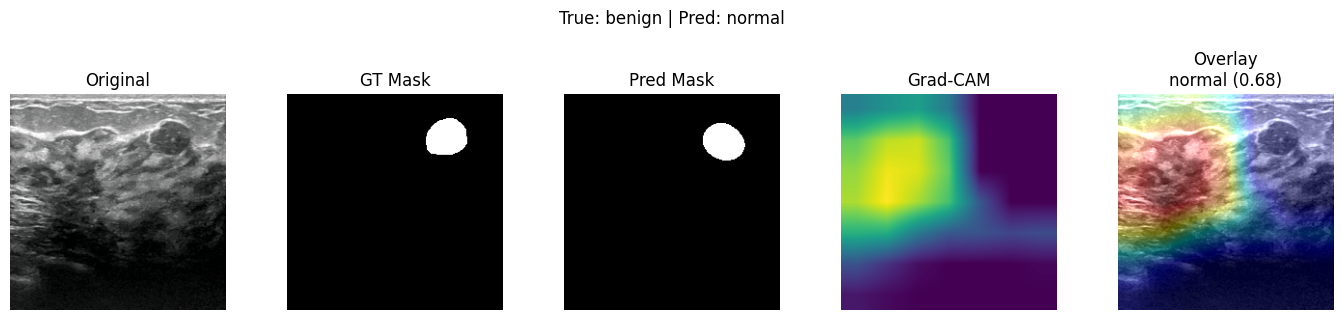

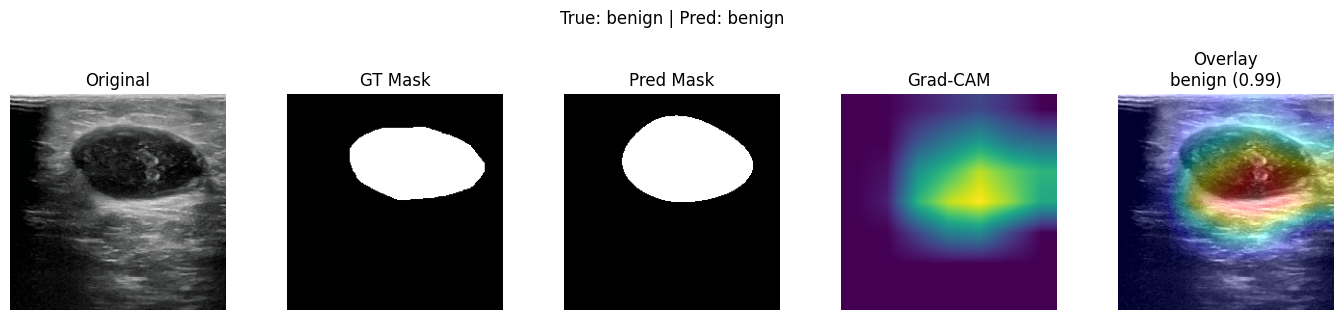

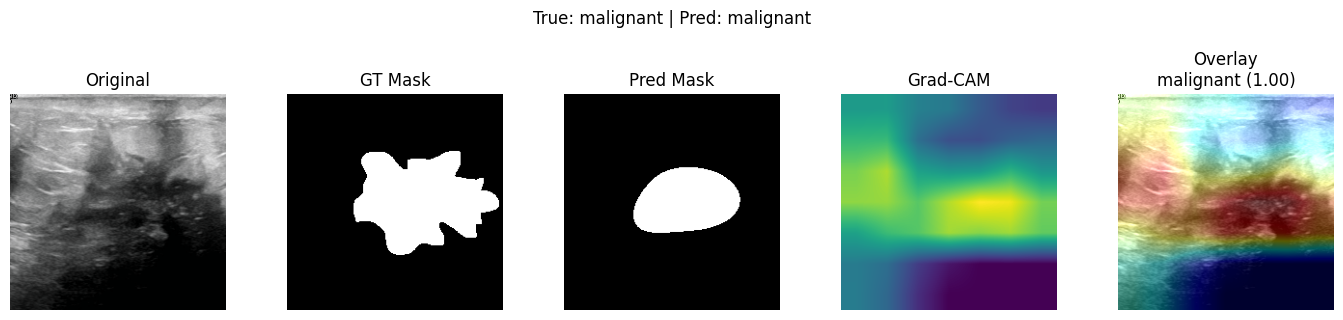

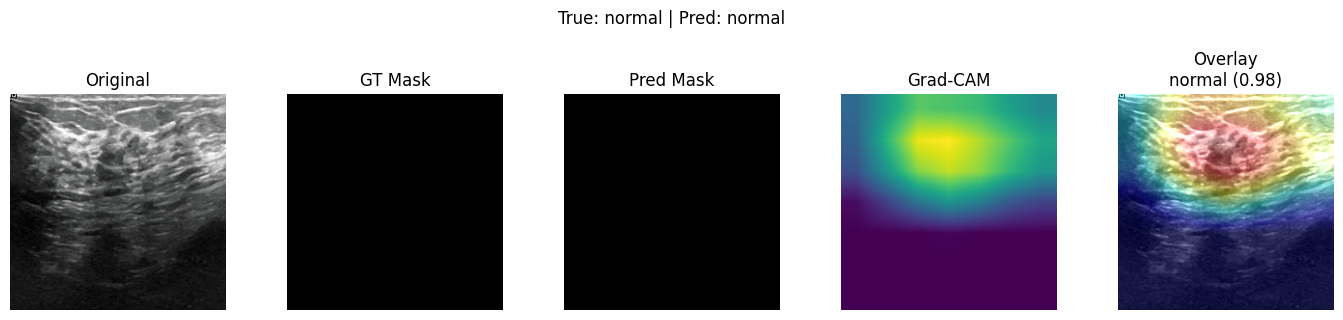

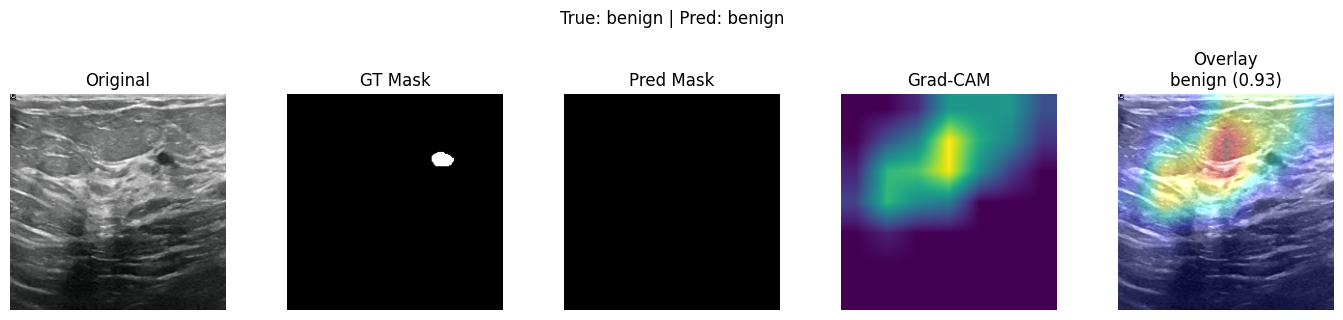

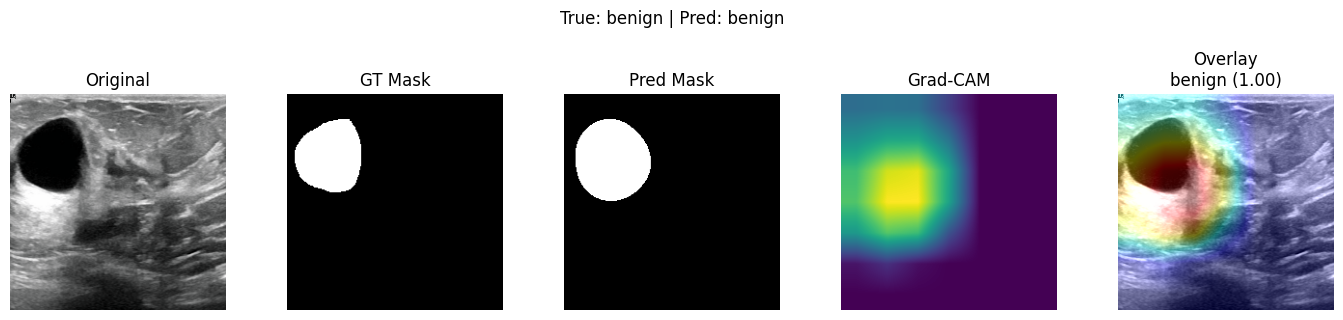

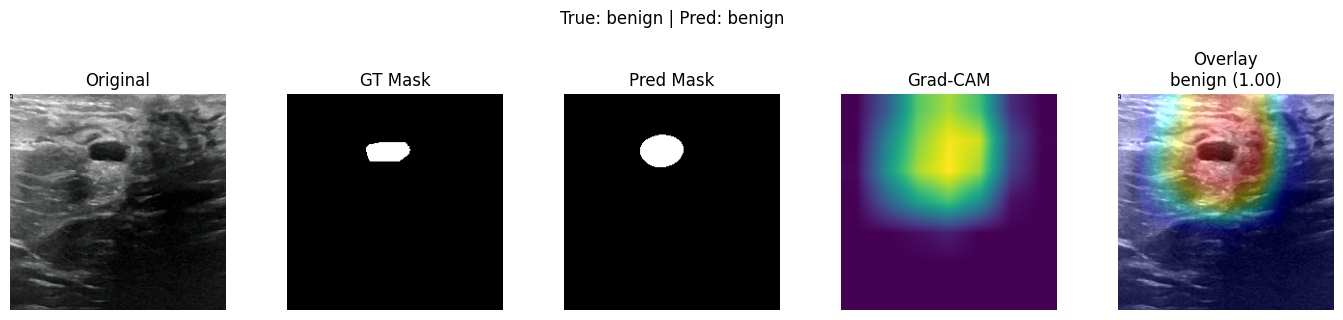

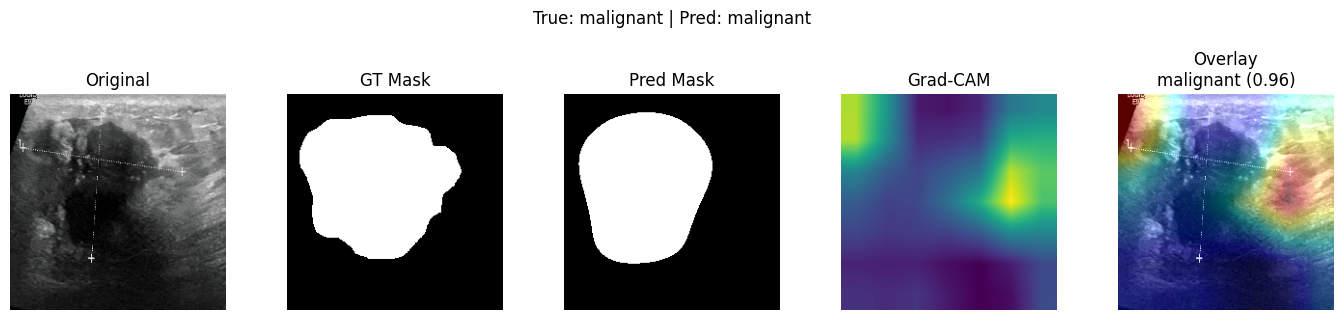

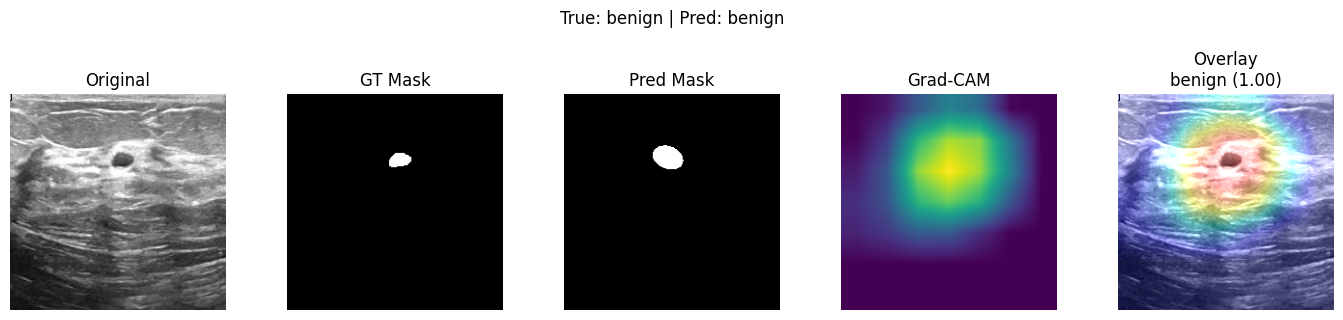

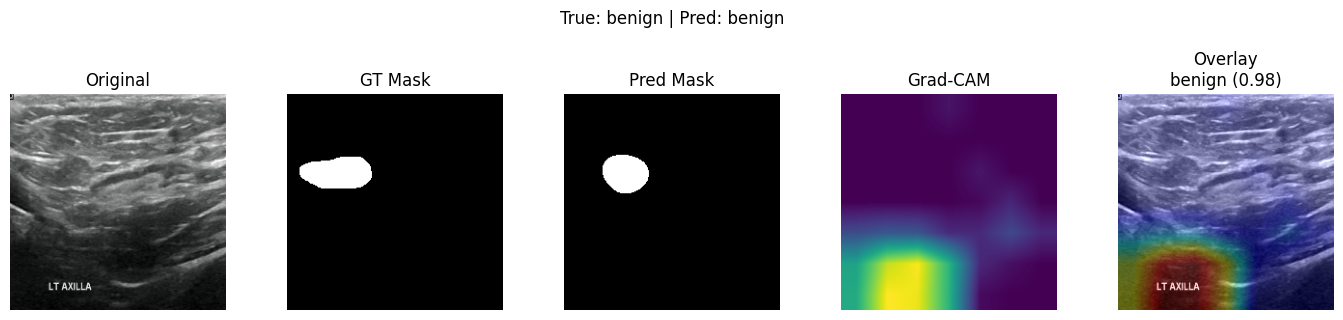

Exported 12 figures to /kaggle/working/figures/


In [18]:
# Saves N five‑panel figures to /kaggle/working/figures/
N = 12
os.makedirs('/kaggle/working/figures', exist_ok=True)

saved = 0
for imgs, masks, labels in val_loader:
    imgs = imgs.to(DEVICE)
    masks_t = masks.to(DEVICE)
    labels_t = torch.as_tensor(labels, device=DEVICE)

    seg_logits, cls_logits = model(imgs)

    for b in range(imgs.size(0)):
        if saved >= N:
            break
        single = imgs[b].unsqueeze(0)
        # fresh CAM engine per sample to avoid stale hooks
        engine = GradCAM(model, get_target_layer(model))
        cam, probs, _ = engine.generate(single)
        engine.close()

        img_uint8   = tensor_to_image_uint8(imgs[b])
        gt_mask_u8  = (masks_t[b,0].detach().float().cpu().numpy() > 0.5).astype(np.uint8) * 255
        pred_mask_u8= logits_to_mask_uint8(seg_logits[b].unsqueeze(0))
        pred_idx  = int(np.argmax(probs))
        pred_name = {0: "benign", 1: "malignant", 2: "normal"}[pred_idx]
        true_name = {0: "benign", 1: "malignant", 2: "normal"}[int(labels_t[b].item())]
        title = f"True: {true_name} | Pred: {pred_name}"
        out_path = f"/kaggle/working/figures/export_{saved+1:03d}.png"
        show_5panel(img_uint8, gt_mask_u8, pred_mask_u8, cam, title, pred_name, float(probs.max()), save_path=out_path)
        saved += 1
    if saved >= N:
        break

print(f"Exported {saved} figures to /kaggle/working/figures/")

In [38]:
import shutil

# Combine both results and figures into one zip
shutil.make_archive("/kaggle/working/export_all", "zip", "/kaggle/working/figures")

print("✅ All files zipped at /kaggle/working/figure_all.zip")


✅ All files zipped at /kaggle/working/figure_all.zip
